# ASSIGNMENT 1 NUMERICAL OPTIMIZATION

In this assignment we will use a direct method and an iterative to solve the system Ax=b. 
The matrix A will be constructed for n=32, n=64, n=128 and the results will be examined separatelly for each of these cases. 

In [2]:
import numpy as np
from scipy import linalg
import time
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky_banded, cho_solve_banded
from scipy import sparse as sp
import sys
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import time

#function used to construct B matrix
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())


def construct_matrixB(n,value):   #values matrix is a list of the values to fill from the diagonal and up.
    B=np.zeros([n,n]) #initialize nxn size matrix with zeros
    #creating upper part of B matrix 
    #in this loop I fill the values per row starting from diagonal
    for i in range(n):
        ind_values=0 #used to loop over values matrix
        for j in range(i,n):
            if ind_values<len(value):#I insert only in the three first cells(starting from diagonal).The rest stays zero.
                B[i,j]=value[ind_values]
                ind_values+=1

    B=symmetrize(B)
    return B

def construct_matrixA(B): #using kroneker product
    A = np.kron(B,np.eye(B.shape[0]))
    temp = np.kron(np.eye(B.shape[0]),B)
    A = A + temp
    return A

def b_matrix(n):
    b = np.ones([n**2]) #creating n^2 matrix with all ones
    return b

#banded matrix is used as input to cholesky_banded:
#the thinking behind this consruction is that we start from the last column going back and when we find a value<>0 
#we fill the banded matrix until the diagonal
def constructing_banded_matrix(A):
    kmax=0
    #in this loop I find the number of the non-zero diagonals
    for col in range(A.shape[0]-1,0,-1):
        if A[0,col]!=0:
            k=col
            if kmax<k:
                kmax=k

    banded = np.zeros((kmax+1,A.shape[0]))
    #Constructing banded_matrix
    for i in range(0,banded.shape[0]):
        for j in range(kmax,A.shape[0],1):
            banded[i,j] = A[j-kmax,j]
        kmax = kmax-1
    return banded



# NOTES

To implement the direct methods I construct a banded matrix manually and a compressed matrix using scipy library.
In order to check the efficiency of the solving methods I print the time to consruct the matrices separately from the solving time. It is also possible to construct these matrices without constructing full A.
Note that the final decision of the optimal solving method is based only on the time to solve the system NOT the time to construct the matrices.

# DIRECT METHODS

# #Solving Ax=b when N=32

For N=32 two direct methods will be demostrated that had the best performance of the ones I tested.
LU decomposition for sparse matrix: It takes as input a Compressed Sparse Row matrix of size 56 bytes as sys.getsizeof demostrates below.
Cholesky decomposition for banded matrices: It takes as input a banded matrix of  size 532592 bytes.
For n=32, LU for sparse matrix is optimal for both time and memory consuption.

In [3]:
# MATRIX N=32
#Constructing Matrix
value=[6,-4,1]
n=32 
B = construct_matrixB(n,value)
A=construct_matrixA(B)
b = b_matrix(n)

#Construct banded matrix to use Cholesky decomposition and count time to construct the matrix
bandtimer_start=time.time()  
A_banded = constructing_banded_matrix(A)
band_timer_end = time.time()

print("Time to construct banded matrix",band_timer_end-bandtimer_start)

#SOLVING USING CHOLESKY DECOMPOSITION
timecholesky = []
repeats=60
#running cholesky banded 60 time in order to get the average time
for i in range(repeats):
    start = time.time()
    
    L_banded = linalg.cholesky_banded(A_banded, lower=False) #cholesky decomposition 
    x_cho_banded = linalg.cho_solve_banded((L_banded, False), b, check_finite=False ) #solver using decomposition
    
    end = time.time()
    timecholesky.append(end-start)



#CHOLESKY_BANDED ACCURACY
acc_cholesky = 1 - np.linalg.norm(np.dot(A,x_cho_banded) - b)/np.linalg.norm(b)
#constructing dataframe to print results
printdf={"METHOD":["CHOLESKY BANDED"],'AVERAGE_TIME': [np.mean(timecholesky)],'STANDARD_DEVIATION':[np.std(timecholesky)],
         'ACCURACY':[acc_cholesky]}

#STORE TIME AND ACCURACY TO CREATE GRAPHS
cho_time32=np.mean(timecholesky)
cho_acc32 = acc_cholesky

#SOLVING USING LU FOR SPARSE MATRIX (superLU package) 
start = time.time()
sA = sp.csc_matrix(A) #Converting A into a Compressed Sparse Row matrix
end = time.time()
print("\nTime to construct compressed matrix: ",end-start)

timeLU=[]
for i in range(60):
    start = time.time()
    L=sp.linalg.splu(sA, permc_spec=None)#Compute the LU decomposition of a sparse, square matrix.
    x_splu = L.solve(b)
    end = time.time()
    timeLU.append(end-start)

#LU SPARSE MATRIX 
acc_splu = 1 - np.linalg.norm(np.dot(A, x_splu) - b)/np.linalg.norm(b)

#STORE TIME AND ACCURACY TO CREATE GRAPHS
LU_time32 = np.mean(timeLU)
LU_acc32 = acc_splu

#Filling Datagrame to fill matrix
printdf['METHOD'].append('SPARSE LU')
printdf['AVERAGE_TIME'].append(np.mean(timeLU))
printdf['STANDARD_DEVIATION'].append(np.std(timeLU))
printdf['ACCURACY'].append(acc_splu)

printdf = pd.DataFrame(printdf)
printdf = printdf[['METHOD', 'AVERAGE_TIME', 'STANDARD_DEVIATION',"ACCURACY"]]
pd.options.display.float_format = '{:,.15f}'.format
display(printdf)





Time to construct banded matrix 0.03815913200378418

Time to construct compressed matrix:  0.01907491683959961


,METHOD,AVERAGE_TIME,STANDARD_DEVIATION,ACCURACY
0,CHOLESKY BANDED,0.014783799648285,0.004093604733907,0.999999999994848
1,SPARSE LU,0.010828904310862,0.003289005502277,0.999999999997624


In [101]:
#MEMORY CONSUPTION UP UNTIL NOW
#Get the size of the matrix in bytes
print("MEMORY FOR N=32")
print("A:",sys.getsizeof(A),"\nA_banded:",sys.getsizeof(A_banded),"\nb:",sys.getsizeof(b),"\ncompressed_matrix:", sys.getsizeof(sA))
print("\nNote: Memory counted in bytes")

MEMORY FOR N=32
A: 8388720 
A_banded: 532592 
b: 8288 
compressed_matrix: 56

Note: Memory counted in bytes


Note on sys.getsizeof function:
All built-in objects will return correct results, but this does not have to hold true for third-party extensions as it is implementation specific.

# Solving Ax=b when N=64

For N=64 the optimal method on the point of view of time is Cholesky banded and LU for sparse matrix is optimal for memory consuption.

CHOLESKY BANDED MEMORY: 4227184 bytes

SPARSE LU MATRIX MEMORY: 56 bytes

In [102]:
# MATRIX N=64
#Constructing Matrix
value=[6,-4,1]
n=64
B = construct_matrixB(n,value)
start = time.time()
A=construct_matrixA(B)
end=time.time()
print("Time to construct A for n=64",end-start)
b = b_matrix(n)

#Construct banded matrix to use Cholesky decomposition and count time to construct the matrix
bandtimer_start=time.time()  
A_banded = constructing_banded_matrix(A)
band_timer_end=time.time()

print("Time to construct banded matrix: ",band_timer_end-bandtimer_start)

#SOLVING USING CHOLESKY DECOMPOSITION
timecholesky = []
repeats=60
#running cholesky banded 60 time in order to get the average time
for i in range(repeats):
    start = time.time()
    
    L_banded = linalg.cholesky_banded(A_banded, lower=False) #cholesky decomposition 
    x_cho_banded = linalg.cho_solve_banded((L_banded, False), b, check_finite=False ) #solver using decomposition
    
    end = time.time()
    timecholesky.append(end-start)



#CHOLESKY_BANDED ACCURACY
acc_cholesky = 1 - np.linalg.norm(np.dot(A,x_cho_banded) - b)/np.linalg.norm(b)
#constructing dataframe to print results
printdf={"METHOD":["CHOLESKY BANDED"],'AVERAGE_TIME': [np.mean(timecholesky)],'STANDARD_DEVIATION':[np.std(timecholesky)],
         'ACCURACY':[acc_cholesky]}

#STORE TIME AND ACCURACY TO CREATE GRAPHS
cho_time64=np.mean(timecholesky)
cho_acc64 = acc_cholesky



#SOLVING USING LU FOR SPARSE MATRIX (superLU package) 
start = time.time()
sA = sp.csc_matrix(A) #Converting A into a Compressed Sparse Row matrix
end = time.time()
print("\nTime to construct compressed matrix: ",end-start)

timeLU=[]
for i in range(60):
    start = time.time()
    L=sp.linalg.splu(sA, permc_spec=None)#Compute the LU decomposition of a sparse, square matrix.
    x_splu = L.solve(b)
    end = time.time()
    timeLU.append(end-start)

#LU SPARSE MATRIX 
acc_splu = 1 - np.linalg.norm(np.dot(A, x_splu) - b)/np.linalg.norm(b)

#STORE TIME AND ACCURACY TO CREATE GRAPHS
LU_time64=np.mean(timeLU)
LU_acc64 = acc_splu

#Filling Datagrame to fill matrix
printdf['METHOD'].append('SPARSE LU')
printdf['AVERAGE_TIME'].append(np.mean(timeLU))
printdf['STANDARD_DEVIATION'].append(np.std(timeLU))
printdf['ACCURACY'].append(acc_splu)

printdf = pd.DataFrame(printdf)
printdf = printdf[['METHOD', 'AVERAGE_TIME', 'STANDARD_DEVIATION',"ACCURACY"]]
pd.options.display.float_format = '{:,.15f}'.format
display(printdf)



Time to construct A for n=64 0.4871349334716797
Time to construct banded matrix:  0.22762656211853027

Time to construct compressed matrix:  0.16745996475219727


,METHOD,AVERAGE_TIME,STANDARD_DEVIATION,ACCURACY
0,CHOLESKY BANDED,0.017310349146525,0.004029225542754,0.999999999963855
1,SPARSE LU,0.038494499524434,0.007788353210227,0.999999999963277


In [103]:
#MEMORY CONSUPTION UP UNTL NOW
#Get the size of the matrix in bytes
print("MEMORY FOR N=64")
print("A:",sys.getsizeof(A),"\nA_banded:",sys.getsizeof(A_banded),"\nb:",sys.getsizeof(b),"\ncompressed_matrix:", sys.getsizeof(sA))
print("\nNote: Memory counted in bytes")

MEMORY FOR N=64
A: 134217840 
A_banded: 4227184 
b: 32864 
compressed_matrix: 56

Note: Memory counted in bytes


# # Solving Ax=b when N=128

For N=128 the optimal method on the point of view of time is Cholesky banded and LU for sparse matrix is optimal for memory consuption.
CHOLESKY BANDED MEMORY: 33685616 bytes

SPARSE LU MATRIX MEMORY: 56 bytes

In [104]:
# MATRIX N=128
#Constructing Matrix
value=[6,-4,1]
n=128
B = construct_matrixB(n,value)
start = time.time()
A=construct_matrixA(B)
end=time.time()
print("Time to construct A for n=128: ",end-start)
b = b_matrix(n)

#Construct banded matrix to use Cholesky decomposition and count time to construct the matrix
bandtimer_start=time.time()  
A_banded = constructing_banded_matrix(A)
band_timer_end=time.time()

print("Time to construct banded matrix",band_timer_end-bandtimer_start)

#SOLVING USING CHOLESKY DECOMPOSITION
timecholesky = []
repeats=35
#running cholesky banded 60 time in order to get the average time
for i in range(repeats):
    start = time.time()
    
    L_banded = linalg.cholesky_banded(A_banded, lower=False) #cholesky decomposition 
    x_cho_banded = linalg.cho_solve_banded((L_banded, False), b, check_finite=False ) #solver using decomposition
    
    end = time.time()
    timecholesky.append(end-start)



#CHOLESKY_BANDED ACCURACY
acc_cholesky = 1 - np.linalg.norm(np.dot(A,x_cho_banded) - b)/np.linalg.norm(b)


#constructing dataframe to print results
printdf={"METHOD":["CHOLESKY BANDED"],'AVERAGE_TIME': [np.mean(timecholesky)],'STANDARD_DEVIATION':[np.std(timecholesky)],
         'ACCURACY':[acc_cholesky]}

#STORE TIME AND ACCURACY TO CREATE GRAPHS
cho_time128=np.mean(timecholesky)
cho_acc128 = acc_cholesky



#SOLVING USING LU FOR SPARSE MATRIX (superLU package) 
start = time.time()
sA = sp.csc_matrix(A) #Converting A into a Compressed Sparse Row matrix
end = time.time()
print("\nTime to construct compressed matrix: ",end-start)

timeLU=[]
for i in range(60):
    start = time.time()
    L=sp.linalg.splu(sA, permc_spec=None)#Compute the LU decomposition of a sparse, square matrix.
    x_splu = L.solve(b)
    end = time.time()
    timeLU.append(end-start)

#LU SPARSE MATRIX 
acc_splu = 1 - np.linalg.norm(np.dot(A, x_splu) - b)/np.linalg.norm(b)

#STORE TIME AND ACCURACY TO CREATE GRAPHS
LU_time128=np.mean(timeLU)
LU_acc128= acc_splu

#Filling Datagrame to fill matrix
printdf['METHOD'].append('SPARSE LU')
printdf['AVERAGE_TIME'].append(np.mean(timeLU))
printdf['STANDARD_DEVIATION'].append(np.std(timeLU))
printdf['ACCURACY'].append(acc_splu)

printdf = pd.DataFrame(printdf)
printdf = printdf[['METHOD', 'AVERAGE_TIME', 'STANDARD_DEVIATION',"ACCURACY"]]
pd.options.display.float_format = '{:,.15f}'.format
display(printdf)




Time to construct A for n=128:  14.050747156143188
Time to construct banded matrix 1.7068517208099365

Time to construct compressed matrix:  2.075538158416748


,METHOD,AVERAGE_TIME,STANDARD_DEVIATION,ACCURACY
0,CHOLESKY BANDED,0.125962257385254,0.008644872240083,0.999999999305139
1,SPARSE LU,0.446368757883708,0.226871078332216,0.999999999474132


In [105]:
#MEMORY CONSUPTION FOR N=128
#Get the size of the matrix in bytes
print("MEMORY FOR N=128")
print("A:",sys.getsizeof(A),"\nA_banded:",sys.getsizeof(A_banded),"\nb:",sys.getsizeof(b),"\ncompressed_matrix:", sys.getsizeof(sA))
print("\nNote: Memory counted in bytes")

MEMORY FOR N=128
A: 2147483760 
A_banded: 33685616 
b: 131168 
compressed_matrix: 56

Note: Memory counted in bytes


# GRAPHS

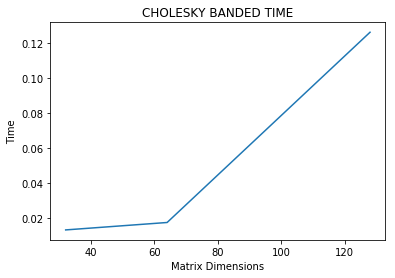

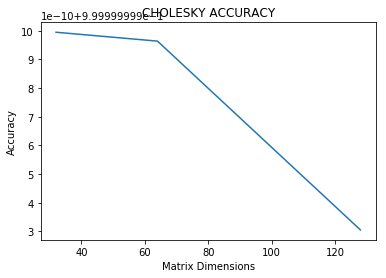

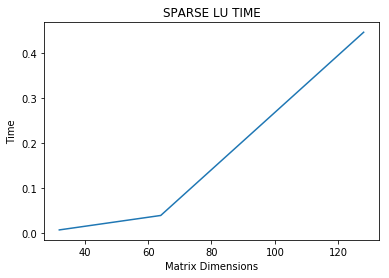

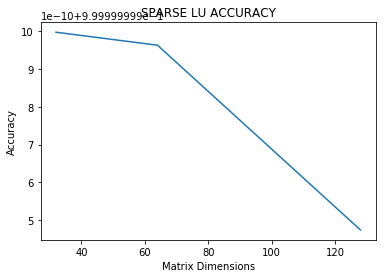

In [106]:

x_axis=[32,64,128]

#CHOLESKY BANDED
time_cho=[cho_time32,cho_time64,cho_time128]
accuracy_cho=[cho_acc32,cho_acc64,cho_acc128]
plt.plot(x_axis,time_cho)
plt.xlabel("Matrix Dimensions")
plt.ylabel("Time")
plt.title("CHOLESKY BANDED TIME")
plt.show()

plt.plot(x_axis,accuracy_cho)
plt.xlabel("Matrix Dimensions")
plt.ylabel("Accuracy")
plt.title("CHOLESKY ACCURACY")
plt.show()

#SPARSE LU
time_LU = [LU_time32,LU_time64,LU_time128]
accuracy_LU = [LU_acc32, LU_acc64, LU_acc128]

plt.plot(x_axis,time_LU)
plt.xlabel("Matrix Dimensions")
plt.ylabel("Time")
plt.title("SPARSE LU TIME")
plt.show()

plt.plot(x_axis,accuracy_LU)
plt.xlabel("Matrix Dimensions")
plt.ylabel("Accuracy")
plt.title("SPARSE LU ACCURACY")
plt.show()



COMMENTS ON GRAPHS: 
We observe that as dimensions increase the accuracy decreases and time increases.

# SUCCESSIVE OVER RELAXATION

Below you will find two SOR implementations. 

The first is an implementation based on the algorithm dercribed in the link( https://en.wikipedia.org/wiki/Successive_over-relaxation in the formulation section ). It is faster than the second implementation in terms of time. I haven't used (1-omega) of the definition as it delays the convergence.

The second implementation is based on the pseudocode on wikipedia and an implementation on github on this link(https://github.com/parkag/SOR/) that uses compressed matrix storage(56 bytes occupied) for A instead of full A.
This implementation is optimal in terms of memory.



In [115]:
def SOR(A,b,omega,maxiter=1000000):
    x = np.ones(len(b))
    error=1
    iteration=1
    diagonal = np.diagonal(A) #storing diagonals of A 
    while error > 10**(-8):
        x_old = x.copy() #initializing x of the iteration that just ended to use both in the calculation of x[i] and error
        for i in range(len(x)):
            #constructing variables before after for each row
            after = np.dot(A[i,:i],x[:i])
            before = np.dot(A[i,i:len(x)], x_old[i:len(x)])
            #calculating x row by row
            x[i] = x[i] + ((omega / diagonal[i])*(b[i] -  after -before))
        
        error = np.linalg.norm(x-x_old)/np.linalg.norm(x)#relative error
        
        iteration+=1
    return x,iteration
    

In [88]:
#SOLUTION BY SUCCESSIVE OVER RELAXATION METHOD
#This method uses the sA sparse matrix that uses very little memory.

def SOR_compressed(A, b,omega, acc, maxiter=1000000):
    x = np.ones(b.shape[0])
    rows = b.shape[0]
    D = sA.diagonal()
    iteration = 0
    xold = np.zeros(b.shape[0])
    error = 1
    while iteration < maxiter and error > acc:
        s = np.zeros(b.shape[0]) #initializing s 
        for row in range(rows):
            cols = A.indices[A.indptr[row]:A.indptr[row+1]] #taking the indexes of the columns of non zero elements of current row
            for j, col in enumerate(cols):
                if col!=row:
                    s[row] += A.data[A.indptr[row]:A.indptr[row+1]][j]*x[col]#indptr gives the index of the first non zero element

            if D[row]!=0.0:
                x[row] += omega*( (b[row]-s[row])/D[row] - x[row])
        iteration +=1
        error = np.linalg.norm(x-xold)/np.linalg.norm(x)
        xold = list(x)
    return x, iteration
    

# RUNNING SOR FOR N=32

In [89]:
#Construct matrices
value=[6,-4,1]
n=32 
B = construct_matrixB(n,value)
A=construct_matrixA(B)
b = b_matrix(n)

#construct compressed matrix A
sA = sp.csr_matrix(A) #Converting A into a Compressed Sparse Row matrix

##### The following code is too time consuming if executed. Please check the results on the graphs without executing  it.

In [91]:
#TUNING OMEGA FOR SOR 
omegas = np.arange(1, 1.96, 0.05) #creates list with omega [1, 0.95] 
SORtime = [] #list to store time for all omegas
iterations = [] #list to store iterations for all omegas 
acc = 10**(-8)
acc_sor = [] #list to store accuracy to check that convergence is reached
for omega in omegas:
    start = time.time()
    res, it = SOR(A,b,omega,acc)
    end = time.time()
    SORtime.append(end-start)
    iterations.append(it)
    acc_sor.append(1 - np.linalg.norm(np.dot(A, res) - b)/np.linalg.norm(b))
    
with open('iterations.pkl', 'wb') as f:
        pickle.dump(iterations, f)

with open('sor_time.pkl', 'wb') as f:
    pickle.dump(SORtime, f)

with open('accuracy_sor.pkl', 'wb') as f:
    pickle.dump(acc_sor, f)

##### The following code is too time consuming if executed. Please check the results on the graphs without executing  it.

In [95]:
#TUNING OMEGA FOR SOR COMPRESSED
omegas = np.arange(1, 1.96, 0.05)
csr_time = []
iterations_csr = []
acc = 10**(-8)
acc_csr = []
for omega in omegas:
    start = time.time()
    res, it = SOR_compressed(sA,b,omega,acc)
    end = time.time()
    csr_time.append(end-start)
    iterations_csr.append(it)
    acc_csr.append(1 - np.linalg.norm(np.dot(A, res) - b)/np.linalg.norm(b))

# GRAPHS

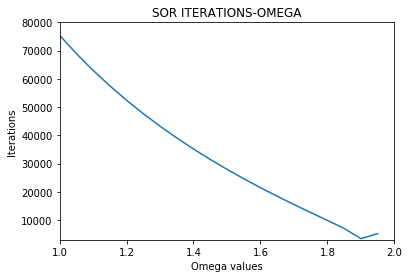

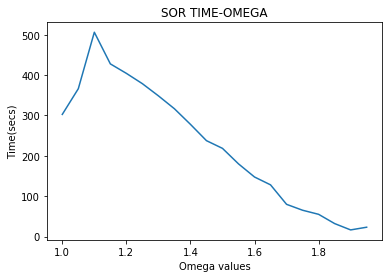

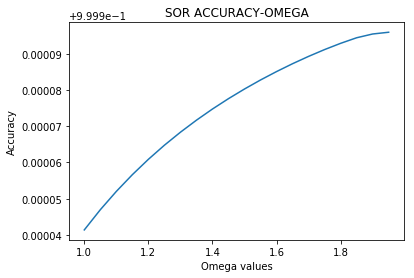

In [7]:
#SOR GRAPHS
plt.plot(omegas, iterations)
plt.xlabel("Omega values")
plt.ylabel("Iterations")
plt.title("SOR ITERATIONS-OMEGA")
plt.ylim(3000, 80000)
plt.xlim(1, 2)

plt.show()

plt.plot(omegas, SORtime)
plt.xlabel("Omega values")
plt.ylabel("Time(secs)")
plt.title("SOR TIME-OMEGA")
plt.show()

plt.plot(omegas, accuracy)
plt.xlabel("Omega values")
plt.ylabel("Accuracy")
plt.title("SOR ACCURACY-OMEGA")
plt.show()


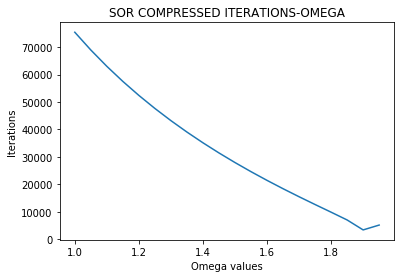

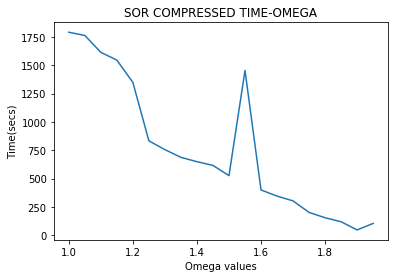

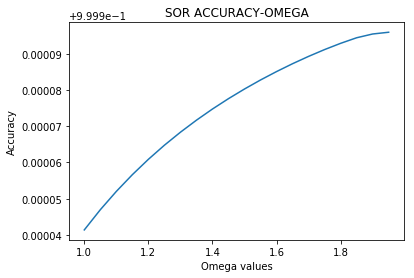

In [9]:
#SOR COMPRESSED GRAPHS
plt.plot(omegas, iterations_csr)
plt.xlabel("Omega values")
plt.ylabel("Iterations")
plt.title("SOR COMPRESSED ITERATIONS-OMEGA")
plt.show()

plt.plot(omegas, csr_time)
plt.xlabel("Omega values")
plt.ylabel("Time(secs)")
plt.title("SOR COMPRESSED TIME-OMEGA")
plt.show()

plt.plot(omegas, acc_csr)
plt.xlabel("Omega values")
plt.ylabel("Accuracy")
plt.title("SOR ACCURACY-OMEGA")
plt.show()

In [109]:
#So for the first SOR omega optimum is 1.95
omega_opt = 1.9

print("SOR")
print("W_optimum for SOR is: ", omega_opt)
print("Optimum Iterations: ", iterations[-2])
print("Optimum time: ",SORtime[-2]," seconds")

#So for the SOR COMPRESSED omega optimum is 1.95
print("\nSOR USING COMPRESSED MATRIX")
print("W_optimum for SOR is: ",omega_opt)
print("Optimum Iterations: ", iterations_csr[-2])
print("Optimum time: ",csr_time[-2] ," seconds")




SOR
W_optimum for SOR is:  1.9
Optimum Iterations:  3409
Optimum time:  16.36152958869934  seconds

SOR USING COMPRESSED MATRIX
W_optimum for SOR is:  1.9
Optimum Iterations:  3408
Optimum time:  48.28074336051941  seconds


##### Calculating wopt using spectral ratio

After calculating spectral radius of transintion matrix of Jacobi we observe that spectral_radius(Tj) > 1 and so it is impossible to calculate omega optimum. 

In [4]:
from numpy import linalg as LA

#Finding L, D, U 
L = np.tril(A, k=-1)
D = np.diag(np.diag(A))
U = np.triu(A, k=1)

Tj =np.dot( np.linalg.inv(D),((1)*L+(1)*U)) #calculating jacobi iterative matrix 
eigenvalues = LA.eigvalsh(Tj) # finding eigenvalues of symmetric positive definite matrix
eigenvalues = [abs(number) for number in eigenvalues] # taking the absolute value of all eigenvalues
spectral_radius = np.max(eigenvalues)  # finding spectral radius

if (1-spectral_radius**2) > 0:
    wopt = 2/(1+np.sqrt(1-spectral_radius**2))
else:
    print("Spectral_radius:",spectral_radius)


Spectral_radius: 1.65481644655


###### From the numbers of iterations point of view,  which is better: To over estimate or to under estimate ωopt?

Observing the Iteration-Οmega graph we conclude that it is better to slightly overestimate omega in SOR than to underestimate it. This is also a rule of thumb in bibliography.